In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchcps.kernel import GaussianKernel
from torchcps.kernel_cnn import KernelConv, KernelMap

In [3]:
# create a datset of 2D signals shifted by a fixed amount
n_samples = 10000
shift = (-17, 3)
n_dimensions = len(shift)

with torch.no_grad():
    # located uniformly in a 50x50 square
    input = 50 * torch.rand(n_samples, n_dimensions) - 25
    # shifted by a fixed amount
    output = input + torch.tensor(shift)[None, :]

In [4]:
class UnpackTuple(nn.Module):
    def forward(self, input):
        return input[0], input[1]


n_channels = 1
filter_kernels = 9
fixed_positions = False
kernel_size = 2

model_factory = lambda: nn.Sequential(
    UnpackTuple(),
    KernelConv(
        filter_kernels=filter_kernels,
        in_channels=1,
        out_channels=n_channels,
        n_dimensions=2,
        kernel_spread=4,
        fixed_positions=fixed_positions,
    ),
    KernelMap(nn.ReLU()),
    KernelConv(
        filter_kernels=filter_kernels,
        in_channels=n_channels,
        out_channels=n_channels,
        n_dimensions=2,
        kernel_spread=8,
        fixed_positions=fixed_positions,
    ),
    KernelMap(nn.ReLU()),
    KernelConv(
        filter_kernels=filter_kernels,
        in_channels=n_channels,
        out_channels=1,
        n_dimensions=2,
        kernel_spread=16,
        fixed_positions=fixed_positions,
    ),
    KernelMap(nn.ReLU()),
).cuda()

In [5]:
from torch.optim import AdamW
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(input.cuda(), output.cuda())
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model = model_factory()
optimizer = AdamW(model.parameters(), lr=1e-2, weight_decay=0)

mse_values = []

pbar = tqdm(dataloader, total=len(dataloader), position=1, leave=False)
for x, y in pbar:
    x = x[:, None, None, ...]
    y = y[:, None, None, :]

    x_weights = torch.ones(x.shape[0], 1, 1, device="cuda")
    y_weights = torch.ones(y.shape[0], 1, 1, device="cuda")

    z, z_weights = model((x, x_weights))

    kernel = GaussianKernel(kernel_size)
    mse = kernel.squared_error(y, y_weights, z, z_weights).mean(0).sum()
    
    mse_values.append(mse.item())
    pbar.set_postfix(loss=mse.item())

    mse.backward()
    optimizer.step()
    optimizer.zero_grad()

/home/damow/.pyenv/versions/3.11.4/envs/torchcps/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/625 [00:00<?, ?it/s]

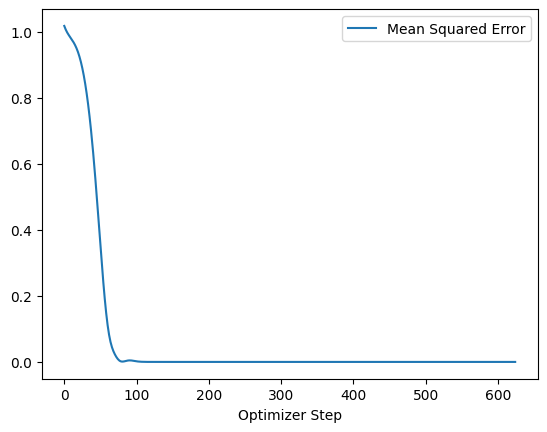

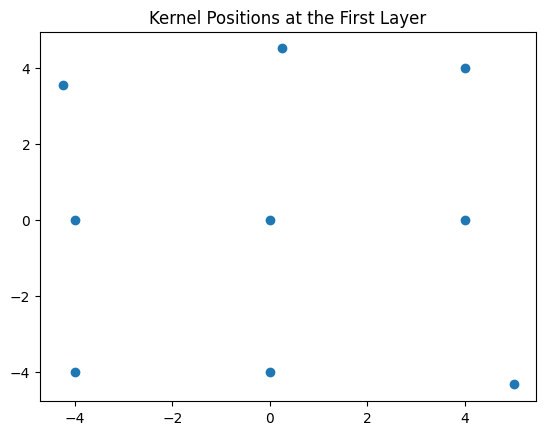

In [6]:
import matplotlib.pyplot as plt

plt.plot(mse_values, label="Mean Squared Error")
plt.xlabel("Optimizer Step")
plt.legend()
plt.show()

# plot the kernel positions
plt.figure()
plt.title("Kernel Positions at the First Layer")
plt.plot(*model[1].kernel_positions.detach().squeeze().cpu().numpy().T, "o")
plt.show()

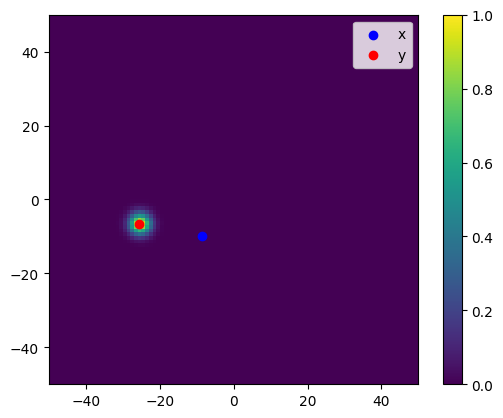

In [9]:
idx = np.random.randint(0, n_samples)

with torch.no_grad():
    x = input[None, None, None, idx].cuda()
    y = output[None, None, None, idx].cuda()

    x_weights = torch.ones(1, 1, 1, device="cuda")
    y_weights = torch.ones(1, 1, 1, device="cuda")

    z, z_weights = model((x, x_weights))

    # squeeze all the tensors
    x = x.squeeze().cpu().numpy()
    y = y.squeeze().cpu().numpy()
    z = z.squeeze()
    z_weights = z_weights.squeeze()

    grid = (
        torch.stack(torch.meshgrid([torch.linspace(-50, 50, 100)] * 2), -1)
        .float()
        .cuda()
        .reshape(-1, 2)
    )
    kernel = GaussianKernel(kernel_size)
    values = kernel(grid, z) @ z_weights
    values = values.reshape(100, 100).cpu().numpy()

# plot the prediction as an intensity
plt.figure()
plt.imshow(values.T, extent=[-50, 50, -50, 50], origin="lower")
plt.scatter(x[0], x[1], c="blue", label="x")
plt.scatter(y[0], y[1], c="red", label="y")
plt.legend()
plt.colorbar()
plt.show()